# LSTM(Long Short Term Memory)
https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr

### 기울기 소실(Gradient Vanishing)과 기울기 폭발(Gradient Exploding)의 원인

Wh:
 [[ 1.78862847  0.43650985  0.09649747]
 [-1.8634927  -0.2773882  -0.35475898]
 [-0.08274148 -0.62700068 -0.04381817]]
[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


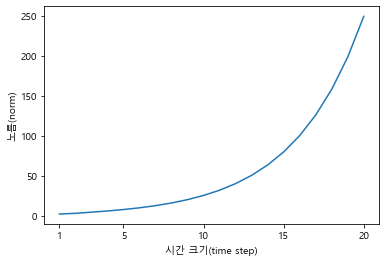

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H, H)          # 기울기 폭발 (스칼라일 경우 Wh가 1보다 큰경 우)  --> NaN
# Wh = np.random.randn(H, H) * 0.5  # 기울기 소실 (스칼라일 경우 Wh가 1보다 작은 경우) --> 0
print('Wh:\n',Wh)


# Norm은 벡터의 길이 혹은 크기를 측정하는 방법(함수)이다
# L1 norm : 벡터의 각 요소의 절대값을 모두 합한 값
# L2 norm : 각 요소의 제곱을 모두 합하여 제곱근을 취한 값
# http://taewan.kim/post/norm/
norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

### 기울기 폭발 대책 : 기울기 클리핑(gradient cliping) 함수 구현
https://wikidocs.net/61375

In [2]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
print('dW1:\n',dW1)
print('dW2:\n',dW2)
grads = [dW1, dW2]
max_norm = 5.0  # threshold, 한계값

## nn_layers.py 에 추가한다
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:  # L2 norm 구하기 , 제곱의 합의 제곱근
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1: # total_norm 이 한계값(max_norm) 보다 클경우
        for grad in grads:
            grad *= rate

print('(dW1) before:', dW1.flatten())
clip_grads(grads, max_norm)
print('(dw1) after:', dW1.flatten())  # 값이 약간 줄어듦

dW1:
 [[6.49144048 2.78487283 6.76254902]
 [5.90862817 0.23981882 5.58854088]
 [2.59252447 4.15101197 2.83525082]]
dW2:
 [[6.93137918 4.40453718 1.56867738]
 [5.44649018 7.80314765 3.06363532]
 [2.21957884 3.87971258 9.3638365 ]]
(dW1) before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
(dw1) after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


### 기울기 소실 방지 : Gated RNN 인 LSTM(Long Short Term Memory)이나  GRU(Gated Recurrent Units ) 사용
### LSTM  : RNN에 기억 셀 𝐜<sub>𝐭</sub> 과 , f , g, i, o 게이트 추가

### LSTM 클래스 구현

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 이전의 상태값이 다음의 값에 영향을 주는 것
# 4개분의 가중치를 모아 아핀 변환을 수행
class LSTM:
    def __init__(self,Wx,Wh,b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),np.zeros_like(b)]
        self.cache = None
        
    # x의 shape은 (N, T, D)로 입력
    # RNN shape
    # W = (V, D) = (Vocab_size, D) => (N, D)
    # (N, T, D) 
    # Wx = (D, H), Wh = (H, H)
    # W와 Wx의 결과 -> (N, D) * (D, H) = (N, H)
    
    def forward(self,x,h_prev,c_prev):
        Wx, Wh, b = self.params         # Wx : (D, 4*H),  Wh : (H, 4*H)
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b     # (N, 4*H) 의 shape
        
        # 동일한 사이즈 4개로 슬라이싱 : f, g, i, o
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = (g * i) + (f * c_prev)
        h_next = o * np.tanh(c_next)
        
        # 곱셈 노드의 역전파, 덧셈 노드의 역전파 등
        # 역전파할 때 재사용해야하기 때문에 계산값들을 캐시에 저장
        # c_next는 tanh 미분할 때 사용하지만, h_next는 역전파 시 사용하지 않음.
        self.cache = (x, h_prev, c_prev, c_next, f, g, i, o)
        
        return h_next, c_next
    
    # 순전파의 출력이 두개니까, 역전파의 입력은 dh_next, dc_next가 될 것.
    # df, dg, di, do = (N X H), (N X H), (N X H), (N X H)
    # 1) dc_next, dh_next가 들어옴.
    # 2) 분기노드의 역전파 = o * dh_next -> tanh의 출력값 => tanh_c_next = np.tanh(c_next)
    
    def backward(self,dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, c_next, f, g, i, o = self.cache
        
        tanh_c_next = np.tanh(c_next)
        
        ds = dc_next + (o * dh_next) * (1 - tanh_c_next ** 2)
        
        dc_prev = ds * f
        
        df = ds * c_prev
        dg = ds * i
        di = ds * g
        do = dh_next * tanh_c_next
        
        # sigmoid 미분 : y * (1 - y)
        # tanh 미분 : 1 - y^2
        # df = df * f * (1 - f)
        df *= f * (1 - f)
        di *= i * (1 - i)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)
        
        # 슬라이싱 된 것을 합친다. -> 수평으로 : np.hstack
        # 나눈 순서 그대로 넣어줘야 함
        dA = np.hstack((df, di, do ,dg)) # 수평으로 합치기 (slice의 역전파)
        
        dWh = np.dot(h_prev.T, dA)      # Matmul의 역전파
        dh_prev = np.dot(dA, Wh.T) 
        
        dWx = np.dot(x.T, dA)           # Matmul의 역전파
        dx = np.dot(dA, Wx.T)

        db = np.sum(dA,axis=0)          # repeat노드의 역전파 : sum()
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev, dc_prev

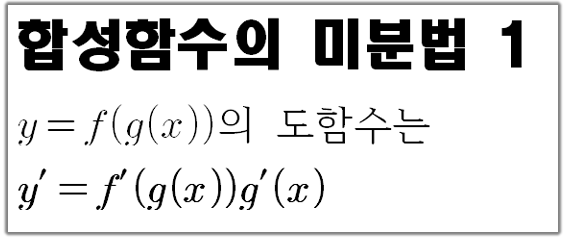

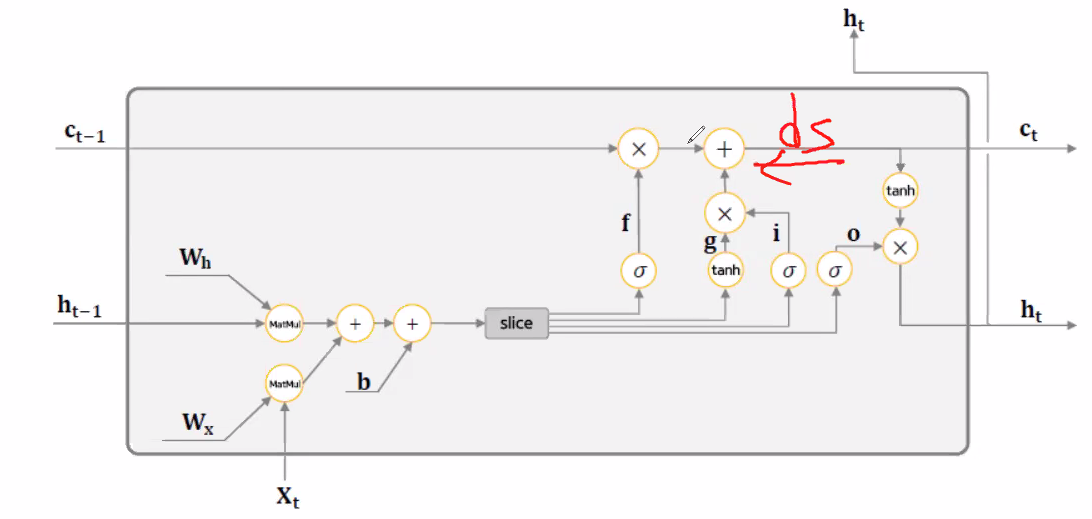

In [8]:
# RNN(LSTM)은 자연어 처리, seq2seq

# Time LSTM 구현

In [10]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),np.zeros_like(b)]
        self.layers = None         

        # Time RNN에서 c가 추가
        self.h, self.c, self.dh = None, None, None 
        
        self.stateful = stateful   # RNN 계층 사이에서 은닉 상태를 인계한다
    
    def set_state(self, h, c):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None
        
    # 순전파
    def forward(self, xs) :  # xs : (N,T,D)
        Wx, Wh, b = self.params
        N, T, D = xs.shape   # N : batch size, T : sequence length , D : input size 
        H = Wh.shape[0]      # H : hidden size
        # Wh = (H, 4*H)
        
        self.layers = []
        hs = np.empty((N,T,H),dtype='f') # (N,T,D) -> (N,D) * (D,H) = (N,H) --> (N,T,H) 출력
        
        if not self.stateful or self.h is None:  
            self.h = np.zeros((N,H),dtype='f')
            
        if not self.stateful or self.c is None:  
            self.c = np.zeros((N,H),dtype='f')
        
        for t in range(T):  # T : sequence length, RNN갯수
            layer = LSTM(*self.params)   # tuple 인수, (Wx, Wh, b)를 튜플 인수로 전달
            self.h, self.s = layer.forward(xs[:,t,:],self.h, self.c) # t: rnn cell 번호, 0,1,2,....
                                                     # self.h 는 hidden layer의 상태값을 저장
            hs[:,t,:] = self.h
            self.layers.append(layer)
            
        return hs # 출력 , (N,T,H)  
    
    # 역전파
    def backward(self,dhs) :  # dhs : (N,T,H)
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]      # Wx : (D, 4*H)
        
        dxs = np.empty((N,T,D), dtype='f')
        dh, dc = 0, 0
        grads = [0,0,0]
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx,dh,dc = layer.backward(dhs[:,t,:] + dh, dc)
            dxs[:,t,:] = dx
        
            for i, grad in enumerate(layer.grads):  # 기울기를 합산
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            
        self.dh = dh

        return dxs

# LSTM을 사용한 언어 모델 : Rnnlm

In [15]:
import pickle

# RNN Language Model
class RNNlm:
    def __init__(self,vocab_size, wordvec_size, hidden_size):
        V,D,H = vocab_size, wordvec_size,hidden_size         # 10000, 100, 100
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V,D)/100).astype('f')

        # Wx, Wh, b가 4*H로 된다. 
        lstm_Wx = (rn(D,4*H) / np.sqrt(D)).astype('f')  # Xavier(=Glorot) Initializer, https://gomguard.tistory.com/184
        lstm_Wh = (rn(H,4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        
        affine_W = (rn(H,V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx,lstm_Wh,lstm_b,stateful=True),
            TimeAffine(affine_W,affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads        

    # 예측
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    # loss값 구하기
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
            
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    # pickle 파일로 모델 저장
    def save_params(self, file_name='RNNlm.pkl'):
        with open(file_name,'wb') as f:
            pickle.dump(self.params,f)
            
    def load_params(self, file_name='RNNlm.pkl'):
        with open(file_name,'rb') as f:
            self.params = pickle.load(f)


# 학습을 위한 코드

In [11]:
from nn_layers import sigmoid,SGD, TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss, RnnlmTrainer
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 20.0
# max_epoch = 4  #  약 30분 소요 , PPL : 약 136.07
max_epoch = 1
max_grad = 0.25  #  기울기 클리핑을 위한 threshold 값

# 학습 데이터 읽기 : 전체 데이터 사용
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test,_,_ = ptb.load_data('test')
vocab_size = len(word_to_id)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력（정답 레이블）


Done
Done


In [18]:
print(vocab_size, len(corpus))

10000 929589


| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 퍼플렉서티 9998.22
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 퍼플렉서티 2438.58
| 에폭 1 |  반복 41 / 9295 | 시간 1[s] | 퍼플렉서티 1307.43
| 에폭 1 |  반복 61 / 9295 | 시간 2[s] | 퍼플렉서티 991.71
| 에폭 1 |  반복 81 / 9295 | 시간 3[s] | 퍼플렉서티 861.82
| 에폭 1 |  반복 101 / 9295 | 시간 5[s] | 퍼플렉서티 671.58
| 에폭 1 |  반복 121 / 9295 | 시간 6[s] | 퍼플렉서티 874.85
| 에폭 1 |  반복 141 / 9295 | 시간 7[s] | 퍼플렉서티 829.53
| 에폭 1 |  반복 161 / 9295 | 시간 8[s] | 퍼플렉서티 898.64
| 에폭 1 |  반복 181 / 9295 | 시간 9[s] | 퍼플렉서티 737.39
| 에폭 1 |  반복 201 / 9295 | 시간 10[s] | 퍼플렉서티 764.43
| 에폭 1 |  반복 221 / 9295 | 시간 11[s] | 퍼플렉서티 750.30
| 에폭 1 |  반복 241 / 9295 | 시간 12[s] | 퍼플렉서티 873.01
| 에폭 1 |  반복 261 / 9295 | 시간 13[s] | 퍼플렉서티 884.66


C:\Users\user\OneDrive - gc.gachon.ac.kr\smlee\GitHub\ai_nlp\03_RNN_LSTM\nn_layers.py:144: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


| 에폭 1 |  반복 281 / 9295 | 시간 14[s] | 퍼플렉서티 854.38
| 에폭 1 |  반복 301 / 9295 | 시간 15[s] | 퍼플렉서티 762.47
| 에폭 1 |  반복 321 / 9295 | 시간 15[s] | 퍼플렉서티 841.73
| 에폭 1 |  반복 341 / 9295 | 시간 17[s] | 퍼플렉서티 801.13
| 에폭 1 |  반복 361 / 9295 | 시간 18[s] | 퍼플렉서티 810.97
| 에폭 1 |  반복 381 / 9295 | 시간 19[s] | 퍼플렉서티 830.50
| 에폭 1 |  반복 401 / 9295 | 시간 20[s] | 퍼플렉서티 890.76
| 에폭 1 |  반복 421 / 9295 | 시간 20[s] | 퍼플렉서티 801.11
| 에폭 1 |  반복 441 / 9295 | 시간 21[s] | 퍼플렉서티 739.94
| 에폭 1 |  반복 461 / 9295 | 시간 22[s] | 퍼플렉서티 722.13
| 에폭 1 |  반복 481 / 9295 | 시간 23[s] | 퍼플렉서티 727.61
| 에폭 1 |  반복 501 / 9295 | 시간 24[s] | 퍼플렉서티 799.73
| 에폭 1 |  반복 521 / 9295 | 시간 25[s] | 퍼플렉서티 851.75
| 에폭 1 |  반복 541 / 9295 | 시간 26[s] | 퍼플렉서티 744.67
| 에폭 1 |  반복 561 / 9295 | 시간 27[s] | 퍼플렉서티 762.01
| 에폭 1 |  반복 581 / 9295 | 시간 28[s] | 퍼플렉서티 658.60
| 에폭 1 |  반복 601 / 9295 | 시간 29[s] | 퍼플렉서티 787.32
| 에폭 1 |  반복 621 / 9295 | 시간 30[s] | 퍼플렉서티 755.75
| 에폭 1 |  반복 641 / 9295 | 시간 30[s] | 퍼플렉서티 778.12
| 에폭 1 |  반복 661 / 9295 | 시간 31[s] | 퍼플렉서티 681.83


| 에폭 1 |  반복 3501 / 9295 | 시간 167[s] | 퍼플렉서티 560.99
| 에폭 1 |  반복 3521 / 9295 | 시간 168[s] | 퍼플렉서티 663.55
| 에폭 1 |  반복 3541 / 9295 | 시간 169[s] | 퍼플렉서티 611.28
| 에폭 1 |  반복 3561 / 9295 | 시간 170[s] | 퍼플렉서티 697.36
| 에폭 1 |  반복 3581 / 9295 | 시간 171[s] | 퍼플렉서티 546.63
| 에폭 1 |  반복 3601 / 9295 | 시간 172[s] | 퍼플렉서티 502.76
| 에폭 1 |  반복 3621 / 9295 | 시간 173[s] | 퍼플렉서티 561.71
| 에폭 1 |  반복 3641 / 9295 | 시간 174[s] | 퍼플렉서티 536.99
| 에폭 1 |  반복 3661 / 9295 | 시간 175[s] | 퍼플렉서티 531.16
| 에폭 1 |  반복 3681 / 9295 | 시간 176[s] | 퍼플렉서티 630.70
| 에폭 1 |  반복 3701 / 9295 | 시간 177[s] | 퍼플렉서티 542.34
| 에폭 1 |  반복 3721 / 9295 | 시간 178[s] | 퍼플렉서티 524.36
| 에폭 1 |  반복 3741 / 9295 | 시간 179[s] | 퍼플렉서티 700.64
| 에폭 1 |  반복 3761 / 9295 | 시간 180[s] | 퍼플렉서티 666.31
| 에폭 1 |  반복 3781 / 9295 | 시간 181[s] | 퍼플렉서티 704.86
| 에폭 1 |  반복 3801 / 9295 | 시간 182[s] | 퍼플렉서티 718.30
| 에폭 1 |  반복 3821 / 9295 | 시간 183[s] | 퍼플렉서티 578.28
| 에폭 1 |  반복 3841 / 9295 | 시간 184[s] | 퍼플렉서티 564.86
| 에폭 1 |  반복 3861 / 9295 | 시간 185[s] | 퍼플렉서티 588.99
| 에폭 1 |  반복

| 에폭 1 |  반복 6661 / 9295 | 시간 310[s] | 퍼플렉서티 526.40
| 에폭 1 |  반복 6681 / 9295 | 시간 311[s] | 퍼플렉서티 558.73
| 에폭 1 |  반복 6701 / 9295 | 시간 311[s] | 퍼플렉서티 626.69
| 에폭 1 |  반복 6721 / 9295 | 시간 312[s] | 퍼플렉서티 557.76
| 에폭 1 |  반복 6741 / 9295 | 시간 313[s] | 퍼플렉서티 481.93
| 에폭 1 |  반복 6761 / 9295 | 시간 314[s] | 퍼플렉서티 448.22
| 에폭 1 |  반복 6781 / 9295 | 시간 315[s] | 퍼플렉서티 586.38
| 에폭 1 |  반복 6801 / 9295 | 시간 316[s] | 퍼플렉서티 559.34
| 에폭 1 |  반복 6821 / 9295 | 시간 317[s] | 퍼플렉서티 545.12
| 에폭 1 |  반복 6841 / 9295 | 시간 318[s] | 퍼플렉서티 517.09
| 에폭 1 |  반복 6861 / 9295 | 시간 319[s] | 퍼플렉서티 669.66
| 에폭 1 |  반복 6881 / 9295 | 시간 320[s] | 퍼플렉서티 509.32
| 에폭 1 |  반복 6901 / 9295 | 시간 321[s] | 퍼플렉서티 485.66
| 에폭 1 |  반복 6921 / 9295 | 시간 322[s] | 퍼플렉서티 443.68
| 에폭 1 |  반복 6941 / 9295 | 시간 323[s] | 퍼플렉서티 599.14
| 에폭 1 |  반복 6961 / 9295 | 시간 323[s] | 퍼플렉서티 437.45
| 에폭 1 |  반복 6981 / 9295 | 시간 324[s] | 퍼플렉서티 510.99
| 에폭 1 |  반복 7001 / 9295 | 시간 325[s] | 퍼플렉서티 532.77
| 에폭 1 |  반복 7021 / 9295 | 시간 326[s] | 퍼플렉서티 542.64
| 에폭 1 |  반복

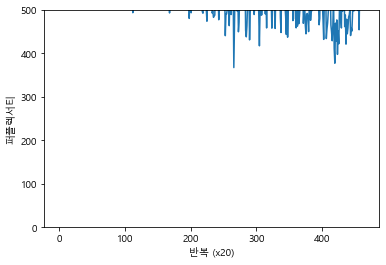

In [19]:
# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)


# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0,500))


In [21]:
import sys
def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('퍼플렉서티 평가 중 ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl


In [23]:
# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)  # test 데이터로 평가
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()


퍼플렉서티 평가 중 ...
1 / 235

C:\Users\user\OneDrive - gc.gachon.ac.kr\smlee\GitHub\ai_nlp\03_RNN_LSTM\nn_layers.py:144: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


234 / 235
테스트 퍼플렉서티:  489.7983578672465


### 개선된 RNNLM 구현


In [24]:
# [1] LSTM 을 2층으로 구현
# [2] 가중치를 공유
# [3] Dropout 사용

class BetterRnnlm():
    

    def predict(self,xs, train_flag=False): 
        for layer in self.drop_layers: # 예측 시에는 dropout을 사용하지 않도록 플래그를 설정
            layer.train_flag = train_flag  
        
        for layer in self.layers:      # 7회 반복
             xs = layer.forward(xs)
        return xs        
            
    def forward(self,xs,ts, train_flag=True):
        score = self.predict(xs, train_flag) # 학습 시에는 dropout을 사용하도록 플래그를 설정
        loss = self.loss_layer.forward(score,ts)
        return loss
    
    def backward(self,dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers): # 7회
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers: # 2회
            layer.reset_state()
        
    def save_params(self, file_name='BetterRnnlm.pkl'):
        with open(file_name,'wb') as f:
            pickle.dump(self.params,f)
            
    def load_params(self, file_name='BetterRnnlm.pkl'):
        with open(file_name,'rb') as f:
            self.params = pickle.load(f)


SyntaxError: unexpected EOF while parsing (<ipython-input-24-783b273387ac>, line 36)

In [25]:
# TimeDropout 클래스
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
# dropout 된 입력 데이터는 0이 된다
# dropout 되지 않은 입력 데이터는  1/(1 - rate)을 곱하여 scale up 시킨다 (droput rate:0~1)

# nn_layers.py에 추가

class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params,self.grads = [],[]
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True   # 학습시에만 True로 설정하여 dropout 적용, 예측시에는 사용하지 않음
        
    def forward(self,xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio            
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs
            
    def backward(self, dout):
        return dout * self.mask  



In [26]:
dropout_ratio = 0.5
dr = TimeDropout(dropout_ratio)

xs = np.arange(1,10).reshape(3,3)
print('xs:\n',xs)

# dr.train_flg = True
drop_xs = dr.forward(xs)
print('drop_xs:\n',drop_xs)

print('-'*30)
flg = np.random.rand(*xs.shape) > dropout_ratio    
print('flg:\n',flg)
print(xs*flg)


xs:
 [[1 2 3]
 [4 5 6]
 [7 8 9]]
drop_xs:
 [[ 0.  4.  6.]
 [ 8.  0.  0.]
 [ 0.  0. 18.]]
------------------------------
flg:
 [[False False  True]
 [ True  True  True]
 [False False False]]
[[0 0 3]
 [4 5 6]
 [0 0 0]]
